# Predicting invasive ductal carcinoma in tissue slices


## Motivation

Inasive ductal carcinoma (IDC) is - with ~ 80 % of cases - one of the most common types of breast cancer. It's malicious and able to form metastases which makes it especially dangerous. Often a biopsy is done to remove small tissue samples. Then a pathologist has to decide whether a patient has IDC, another type of breast cancer or is healthy. In addition sick cells need to be located to find out how advanced the disease is and which grade should be assigned. This has to be done manually and is a time consuming process. Furthermore the decision depends on the expertise of the pathologist and his or her equipment. Therefor deep learning could be of great help to automatically detect and locate tumor tissue cells and to speed up the process. In order to exploit the full potential one could build a pipeline using massive amounts of tissue image data of various hospitals that were evaluated by different experts. This way one would be able to overcome the dependence on the pathologist which would be especially useful in regions where no experts are available .      

## Our goal

As we started with this analysis we asked ourselves if we would be able to improve the results that were presented 2014 in the paper [Automatic detection of invasive ductal carcinoma in whole slide images with Convolutional Neural Networks](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.725.4294&rep=rep1&type=pdf) of professor [Anant Madabhushi](https://case.edu/medicine/ccir/faculty/anant-madabhushi) and his group. Many years have passed by since then and it's very likely that all methods used in the paper have already been changed, improved and that new research has already been done. Nonetheless it's a very good exercise to practice or develop own deep learning and data science skills.


## Methods presented in the paper

Collecting information... ;-)

* In the paper tissue slices of 162 patients were used all having IDC (113 used for training and 49 for validation)
* One pathologist was used to determine regions of IDC given a tissue slice 
* evaluation metric: F1 score and balanced accuracy


* Our goal: Given a patient and a patch of a tissue slice predict wheather it contains IDC or not.
    * 3 possibilities: healthy tissue, IDC, another subtype of breast cancer
* business case: prediction so far is done manually by pathologists and varies from expert to expert. The goal is to assist with an automatic detection of tumors (not expert dependent). 


## Table of contents

1. [What is meant by invasive ductal carcinoma?](#intro) 
2. [Preparation & peek at the data structure](#prep)
    * [Loading packages and settings](#setup)
    * [Exploring the data structure](#explorestructure)
3. [Exploratory analysis](#eda)
    * [What do we know about our data?](#data)
    * [Looking at healthy and invasive ductal carcinoma patches](#patches)
    * [Visualising the breast tissue](#tissue)
4. [Setting up the machine learning workflow](#workflow)
    * [Settings](#ml_settings)
    * [Validation strategy](#validation)
    * [Target distributions](#target_dists)
    * [Creating pytorch image datasets](#image_datasets)
    * [Creating pytorch dataloaders](#dataloaders)
    * [Defining the model structure](#model_structure)
    * [Setting up the loss function](#loss_eva)
    * [Selecting an evaluation metric](#e_metric)
    * [Building the training loop](#train_loop)
    * [Searching for an optimal cyclical learning rate](#lr_cycle_optima)
    * [Performing the training or loading results](#run)
5. [Exploring results and errors](#error_analysis)
    * [Loss convergence](#losses)
    * [The probability landscape of invasive ductal carcinoma](#landscape)
    * [Going into details](#details)
7. [Conclusion](#conclusion)


## What is meant by invasive ductal carcinoma? <a class="anchor" id="intro"></a>

<a title="Mikael Häggström, M.D. - Author info - Reusing images [CC BY (https://creativecommons.org/licenses/by/2.5)]" href="https://commons.wikimedia.org/wiki/File:Lobules_and_ducts_of_the_breast.jpg"><img width="309" alt="Lobules and ducts of the breast" style="float:left; margin:0px 15px 15px 15px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Lobules_and_ducts_of_the_breast.jpg/256px-Lobules_and_ducts_of_the_breast.jpg"></a>


This illustration created [Mikael Häggström](https://commons.wikimedia.org/wiki/File:Lobules_and_ducts_of_the_breast.jpg) shows the anatomy of a healthy breast. One can see the lobules, the glands that can produce milk which flews through the milk ducts. Ductal carcinoma starts to develop in the ducts whereas lobular carcinoma has its origin in the lobules. Invasive carcinoma is able to leave its initial tissue compartment and can form metastases. 

# Preparation & peek at the data structure <a class="anchor" id="prep"></a>

## Loading packages and setting <a class="anchor" id="setup"></a>

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight


from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm

## Exploring the data structure <a class="anchor" id="explorestructure"></a>

In [2]:
files = listdir(r"C:\Users\HP\Metis\my_fifth_project\Breast Histology Images")
print(len(files))

279


In [3]:
files[0:10]

['10253',
 '10254',
 '10255',
 '10256',
 '10257',
 '10258',
 '10259',
 '10260',
 '10261',
 '10262']

In [4]:
base_path = r"C:\Users\HP\Metis\my_fifth_project\Breast Histology Images"
folder = listdir(base_path)
len(folder)

279

Almost 280 patients. That's a small number compared to the expected number of patients one would like to analyse with our algorithm after deployment. **Consequently overfitting to this specific patient distribution is very likely and we need to take care about the generalization performance of our model**. 

### How many patches do we have in total?

Our algorithm needs to decide whether an image patch contains IDC or not. Consequently not the whole patient tissue slice but the single patches have to be considered as input to our algorithm. How many of them do we have in total?

In [5]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + "\\"+ patient_id 
        class_path = patient_path + "\\" + str(c)
        print (class_path)
        subfiles = listdir(class_path)
        total_images += len(subfiles)

C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10253\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10254\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10254\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10255\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10255\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10256\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10256\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10257\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10257\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10258\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10258\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10259\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\10259\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\102

C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12870\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12871\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12871\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12872\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12872\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12873\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12873\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12875\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12875\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12876\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12876\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12877\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12877\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\12878\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\128

C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13461\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13462\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13462\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13591\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13591\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13613\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13613\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13616\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13616\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13617\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13617\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13666\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13666\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\13687\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\136

C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16550\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16551\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16551\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16552\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16552\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16553\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16553\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16554\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16554\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16555\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16555\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16568\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16568\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\16569\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\165

C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9255\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9256\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9256\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9257\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9257\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9258\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9258\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9259\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9259\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9260\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9260\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9261\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9261\1
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9262\0
C:\Users\HP\Metis\my_fifth_project\Breast Histology Images\9262\1
C:\Users\H

In [6]:
total_images

277524

Ok, roughly 280000 images. To feed the algorithm with image patches it would be nice to store the path of each image. This way we can load batches of images only one by one without storing the pixel values of all images. 

### Storing the image_path, patient_id and the target

In [7]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path +"\\"+ patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  

data.head()

patient_id                                               path target
0      10253  C:\Users\HP\Metis\my_fifth_project\Breast Hist...      0
1      10253  C:\Users\HP\Metis\my_fifth_project\Breast Hist...      0
2      10253  C:\Users\HP\Metis\my_fifth_project\Breast Hist...      0
3      10253  C:\Users\HP\Metis\my_fifth_project\Breast Hist...      0
4      10253  C:\Users\HP\Metis\my_fifth_project\Breast Hist...      0

Ok, now for each patient we know the path for each patch as well as if it contains IDC or not (the target).

In [8]:
data.shape

(277524, 3)

No surprise. This matches the total number of patches. 

# Exploratory analysis <a class="anchor" id="eda"></a>

## What do we know about our data? <a class="anchor" id="data"></a>

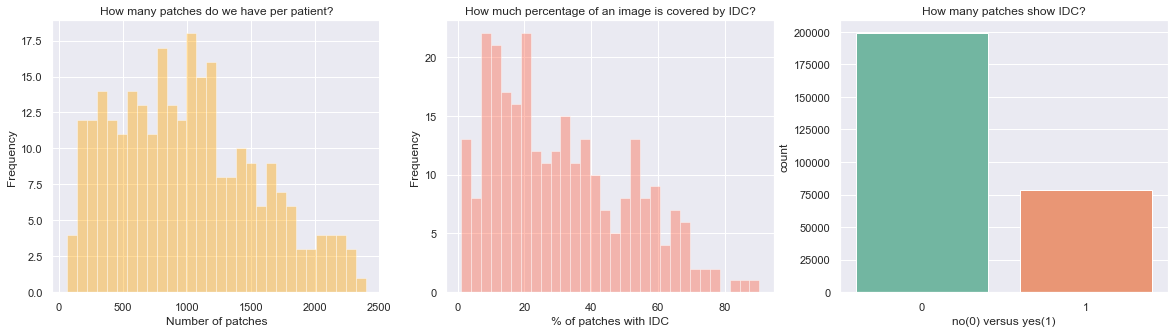

In [9]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");

sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");

sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

### Insights

1. The number of image patches per patient varies a lot! **This leads to the questions whether all images show the same resolution of tissue cells of if this varies between patients**. 
2. Some patients have more than 80 % patches that show IDC! Consequently the tissue is full of cancer or only a part of the breast was covered by the tissue slice that is focused on the IDC cancer. **Does a tissue slice per patient cover the whole region of interest?**
3. The **classes of IDC versus no IDC are imbalanced**. We have to check this again after setting up a validation strategy and find a strategy to deal with class weights (if we like to apply them).

## Looking at healthy and cancer patches <a class="anchor" id="patches"></a>

In [10]:
data.target = data.target.astype(np.int)

In [11]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

### Cancer patches

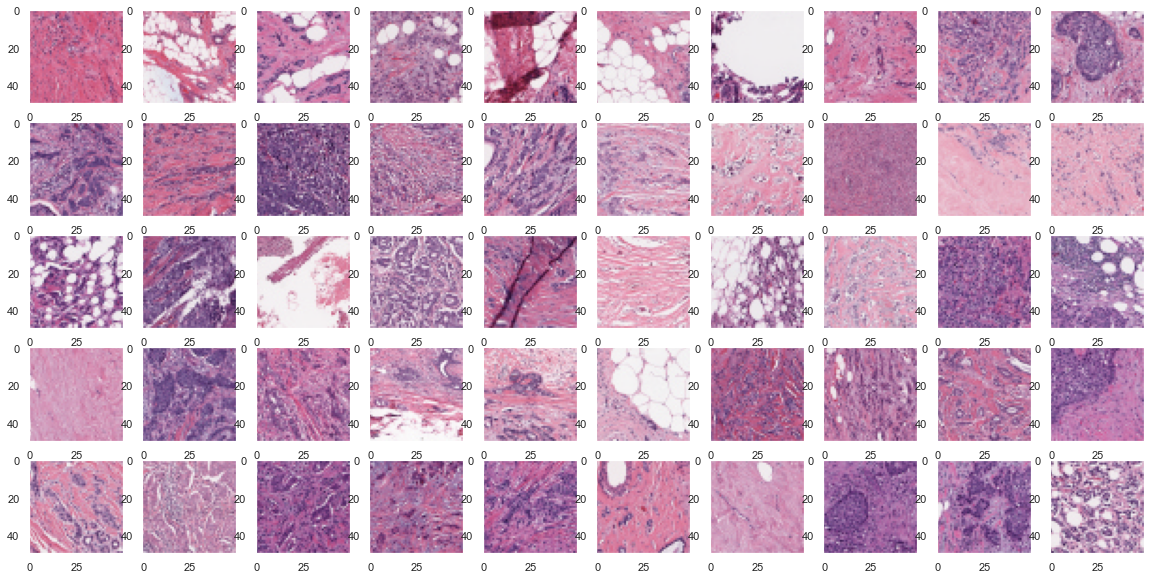

In [16]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Healthy patches

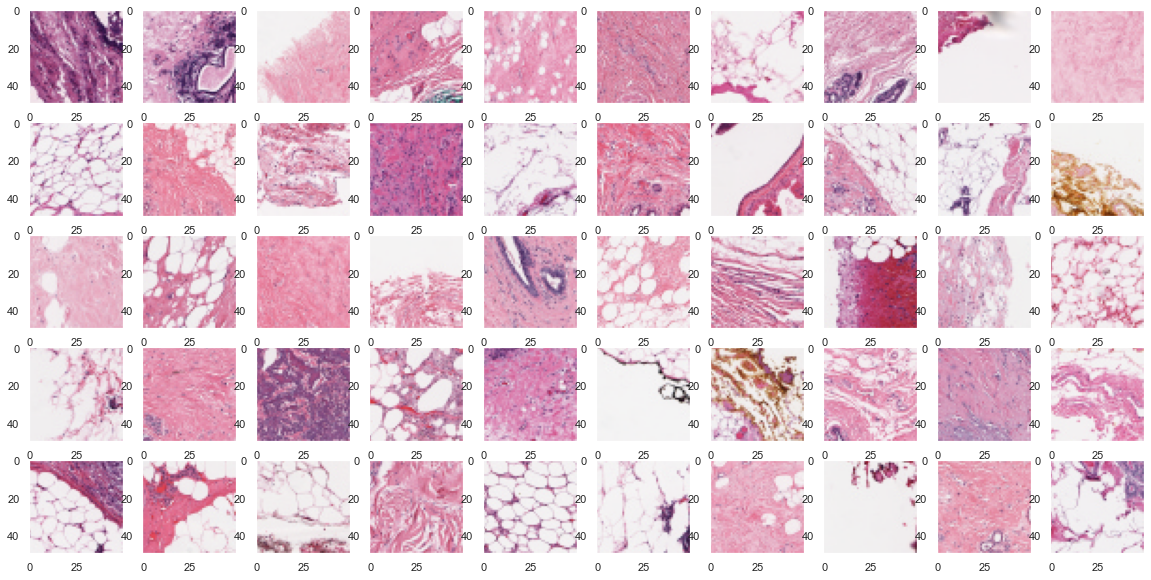

In [17]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

### Insights

* Sometimes we can find artifacts or incomplete patches that have smaller size than 50x50 pixels. 
* Patches with cancer look more violet and crowded than healthy ones. Is this really typical for cancer or is it more typical for ductal cells and tissue?
* Though some of the healthy patches are very violet colored too!
* Would be very interesting to hear what criteria are important for a pathologist.
* I assume that the wholes in the tissue belong to the mammary ducts where the milk can flow through. 

## Visualising the breast tissue <a class="anchor" id="tissue"></a>

This part is a bit tricky! We have to extract all coordinates of image patches that are stored in the image names. Then we can use the coordinates to reconstruct the whole breast tissue of a patient. This way we can also explore how diseased tissue looks like compared to healthy ones. To simplify this task let's write a method that takes a patient and outcomes a dataframe with coordinates and targets.

In [18]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = base_path + "\\" + patient_id + "\\" + cancer_id
    files = listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    dataframe.loc[:, "target"] = np.int(cancer_id)
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    patient_df = df_0.append(df_1)
    return patient_df

In [19]:
example = get_patient_dataframe(data.patient_id.values[0])
example.head()

x     y  target                                               path
0  1001  1001       0  C:\Users\HP\Metis\my_fifth_project\Breast Hist...
1  1001  1051       0  C:\Users\HP\Metis\my_fifth_project\Breast Hist...
2  1001  1101       0  C:\Users\HP\Metis\my_fifth_project\Breast Hist...
3  1001  1151       0  C:\Users\HP\Metis\my_fifth_project\Breast Hist...
4  1001  1201       0  C:\Users\HP\Metis\my_fifth_project\Breast Hist...

Ok, now we have the coordinates for each patch, its path to load the image and its target information.

### Binary target visualisation per tissue slice <a class="anchor" id="binarytissue"></a>

Before we will take a look at the whole tissue let's keep it a bit simpler by looking at the target structure in the x-y-space for a handful of patients:

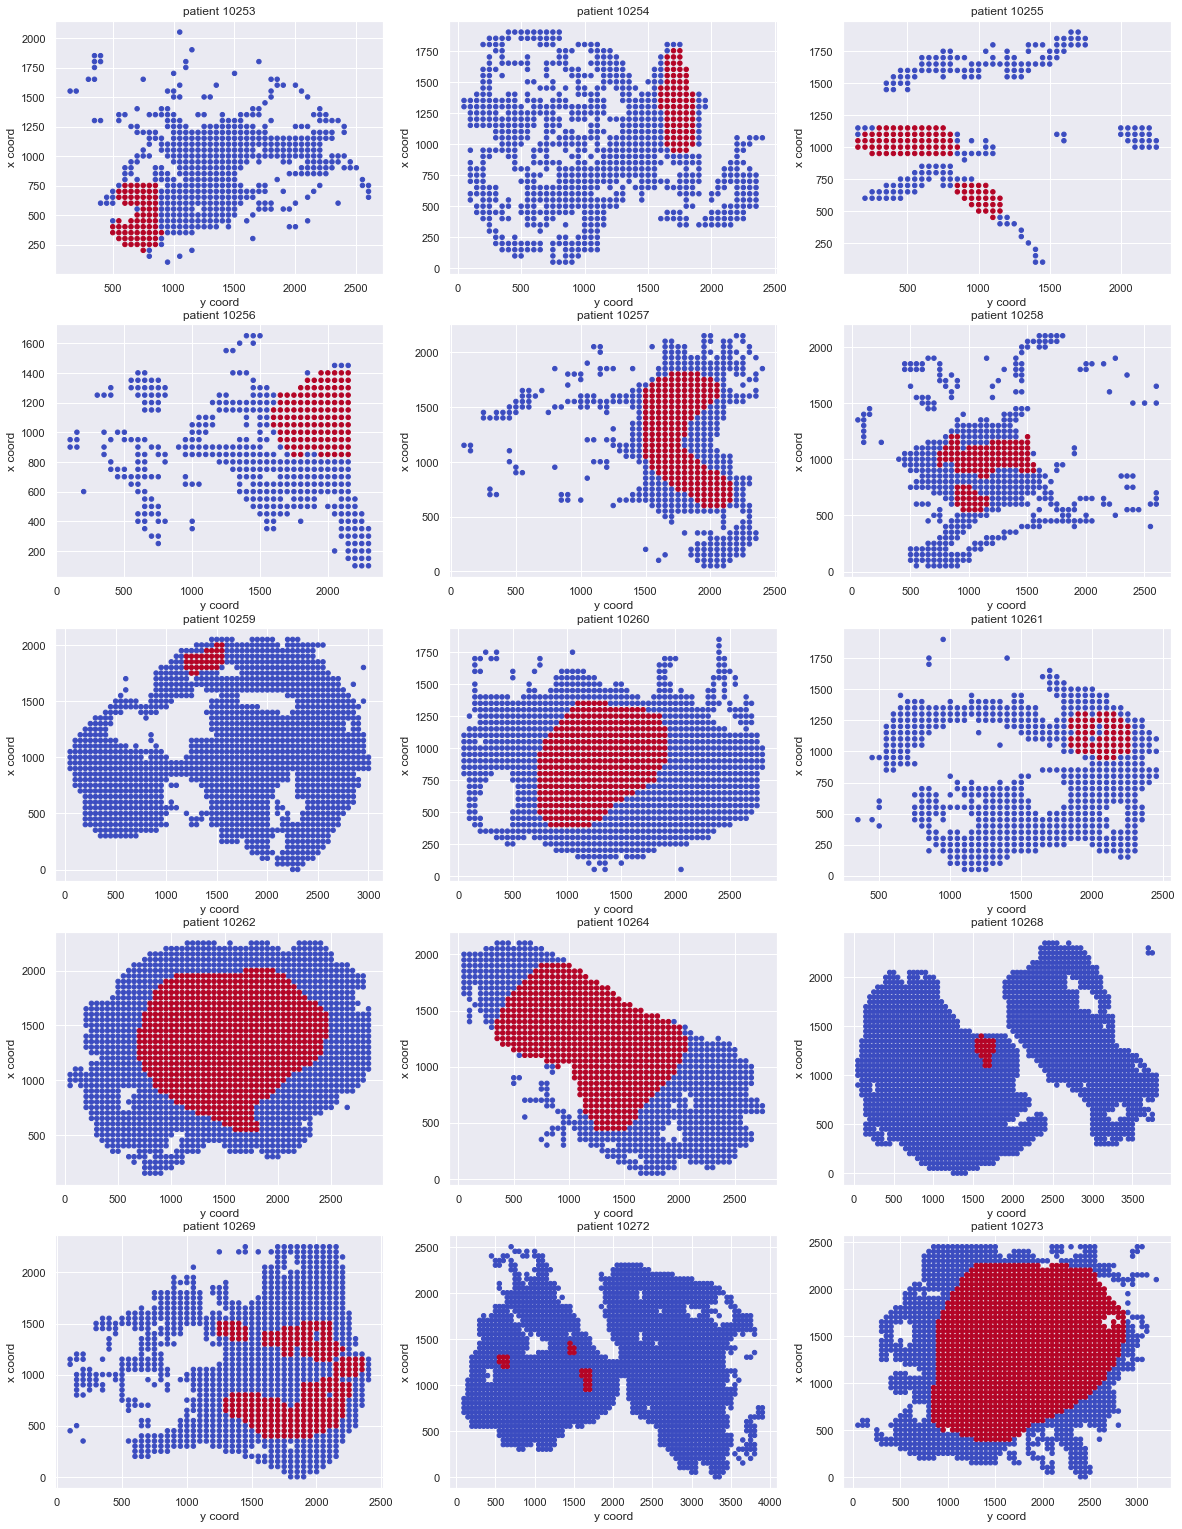

In [20]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

### Insights

* Sometimes we don't have the full tissue information. It seems that tissue patches have been discarded or lost during preparation. 
* Reading the paper (link!) that seems to be related to this data this could also be part of the preprocessing.

### Visualising the breast tissue images <a class="anchor" id="tissueimages"></a>

Ok, now it's time to go one step deeper with our EDA. Given the coordinates of image patches we could try to reconstruct the whole tissue image (not only the targets). 

In [21]:
def visualise_breast_tissue(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)
    max_point = [example_df.y.max()-1, example_df.x.max()-1]
    grid = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()
    mask_proba = np.zeros(shape = (max_point[0] + 50, max_point[1] + 50, 1)).astype(np.float)
    
    broken_patches = []
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            
            x_coord = np.int(example_df.x.values[n])
            y_coord = np.int(example_df.y.values[n])
            x_start = x_coord - 1
            y_start = y_coord - 1
            x_end = x_start + 50
            y_end = y_start + 50

            grid[y_start:y_end, x_start:x_end] = image
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0
            if pred_df is not None:
                
                proba = patient_df[
                    (patient_df.x==x_coord) & (patient_df.y==y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = np.float(proba)

        except ValueError:
            broken_patches.append(example_df.path.values[n])
    
    
    return grid, mask, broken_patches, mask_proba

Let's use an example patient with id 13616: 

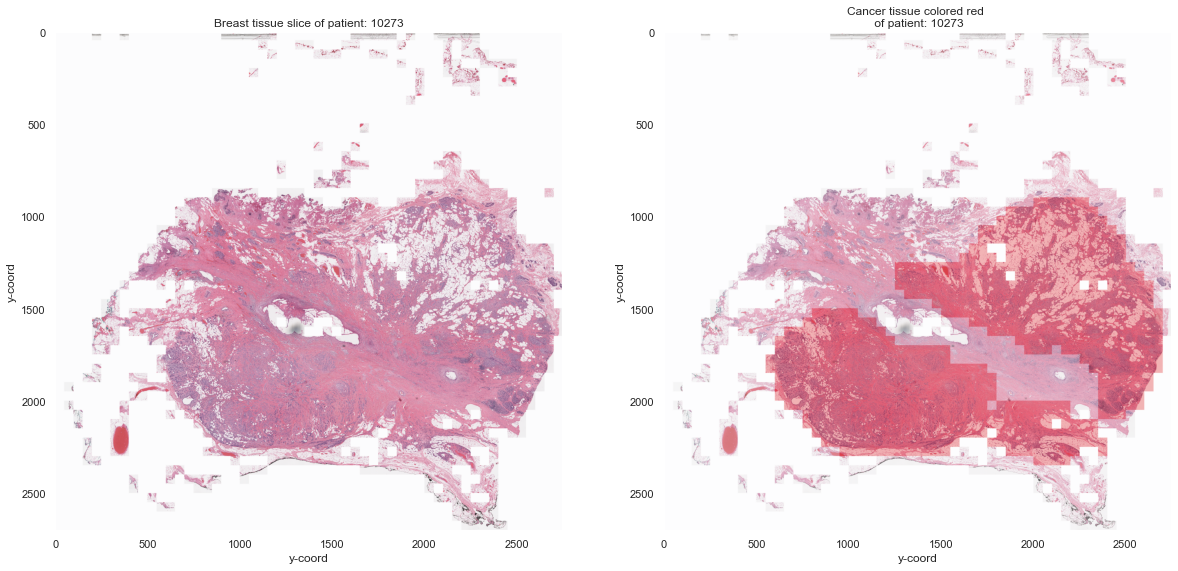

In [22]:
example = "13616"
grid, mask, broken_patches,_ = visualise_breast_tissue(example)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(grid, alpha=0.9)
ax[1].imshow(mask, alpha=0.8)
ax[1].imshow(grid, alpha=0.7)
ax[0].grid(False)
ax[1].grid(False)
for m in range(2):
    ax[m].set_xlabel("y-coord")
    ax[m].set_ylabel("y-coord")
ax[0].set_title("Breast tissue slice of patient: " + patient_id)
ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

### Insights

* The tissue on the left is shown without target information.
* The image on the right shows the same tissue but cancer is stained with intensive red color. 
* Comparing both images it seems that darker, more violet colored tissue has a higher chance to be cancer than those with rose color. 
* But as one can see it's not always the case. So we need to ask ourselves if violet tissue patches have more mammary ducts than rose ones. If this is true we have to be careful. Our model might start to learn that mammary ducts are always related to cancer! 

Sometimes it's not possible to load an image patch as the path is ill defined. But in our case, we were able to load them all:

In [23]:
broken_patches

[]